In [4]:
%matplotlib inline
import math
import time
import pandas as pd
import numpy as np
import lime
import lime.lime_tabular
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.decomposition import PCA, SparsePCA, TruncatedSVD
from sklearn.ensemble import *
from sklearn.preprocessing import normalize
import math
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn.metrics import accuracy_score, plot_confusion_matrix, confusion_matrix as cm
from sklearn.preprocessing import normalize
import seaborn as sn
import keras
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils.np_utils import to_categorical
from itertools import combinations 

In [5]:
df_train = pd.read_csv('train.csv')

# normalization
col_normalize = ['Aspect','Slope','Horizontal_Distance_To_Hydrology','Vertical_Distance_To_Hydrology', 'Hillshade_9am','Hillshade_Noon','Hillshade_3pm','Horizontal_Distance_To_Fire_Points']
df_train_norm = df_train.copy()
df_train_norm['Distance_To_Hydrology'] = (df_train_norm['Horizontal_Distance_To_Hydrology']**2 + df_train_norm['Vertical_Distance_To_Hydrology']**2)**(1/2)
df_train_norm[col_normalize] = normalize(df_train[col_normalize])
df_train_norm['log_Horizontal_Distance_To_Roadways'] = (df_train['Horizontal_Distance_To_Roadways']+1).apply(np.log)
df_train_norm['log_Elevation'] = ((df_train_norm['Elevation']**1.5)+1).apply(np.log)
df_train_norm.drop(columns=['Elevation','Horizontal_Distance_To_Roadways'])


,Id,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,...,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type,Distance_To_Hydrology,log_Horizontal_Distance_To_Roadways,log_Elevation
0,1,0.008102,0.000477,0.040989,0.000000,0.035111,0.036858,0.023513,0.997552,1,...,0,0,0,0,0,0,5,258.000000,6.236370,11.792598
1,2,0.008976,0.000321,0.033980,-0.000962,0.035262,0.037666,0.024203,0.997755,1,...,0,0,0,0,0,0,5,212.084889,5.968708,11.789127
2,3,0.022641,0.001466,0.043653,0.010587,0.038115,0.038766,0.021989,0.997010,1,...,0,0,0,0,0,0,2,275.769832,8.064951,11.908210
3,4,0.024883,0.002890,0.038850,0.018943,0.038208,0.038208,0.019586,0.997096,1,...,0,0,0,0,0,0,2,269.235956,8.036250,11.898012
4,5,0.007277,0.000323,0.024740,-0.000162,0.035574,0.037838,0.024255,0.998023,1,...,0,0,0,0,0,0,5,153.003268,5.971262,11.792020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15115,15116,0.175948,0.016654,0.186809,0.005068,0.123091,0.181740,0.154950,0.928252,0,...,0,0,0,0,0,0,3,258.094944,6.493754,11.798941
15116,15117,0.079296,0.012451,0.414829,0.127791,0.163179,0.144830,0.059636,0.868323,0,...,0,0,0,0,0,0,3,662.354890,6.428105,11.796637
15117,15118,0.103008,0.019218,0.280582,0.089940,0.192180,0.169118,0.063804,0.912469,0,...,0,0,0,0,0,0,3,383.293621,5.817111,11.731269
15118,15119,0.160860,0.026971,0.209985,0.097287,0.220581,0.228287,0.114625,0.897735,0,...,0,0,0,0,0,0,3,240.260276,5.493061,11.728257


In [6]:
kfold = model_selection.KFold(n_splits=10, random_state=0, shuffle=True)
np.set_printoptions(precision=5)
def score_model(model,df, return_val=False, return_train=False, display=True, return_acc=False, return_time=False, show_weights=False):
    X , Y = df.drop(columns=['Id','Cover_Type']).to_numpy(), df.Cover_Type.to_numpy()
    X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=.33, random_state=0)
    start = time.time()
    results = model_selection.cross_val_score(model, X, Y, cv=kfold)
    model.fit(X_train, y_train)
    pred = model.predict(X_val)
    acc = accuracy_score(y_val, pred)
    end = time.time()
    print('\nModel:',type(model).__name__)
    print('\tcv acc:', round(results.mean(),4))
    print('\tsplit acc:', round(acc,4))
    print('\ttime taken:', round(end-start, 4))
    if display:
        matrix = cm(y_val, pred)
        print('\t', matrix.diagonal() / matrix.sum(axis=1))

        disp = plot_confusion_matrix(model, X_val, y_val, display_labels=set(y_train), cmap=plt.cm.Blues, normalize='true')
        plt.show()
    
    if show_weights:
        for w,k in sorted(list(zip(model.feature_importances_, df.drop(columns=['Id','Cover_Type']).columns)), key=lambda x: x[0]):
            print(k,w)
            
    # return all data
    return_data = [model]
    if return_train:
        return_data += [X_train, y_train]
    if return_val:
        return_data += [X_val, y_val]
    if return_acc:
        return_data += [acc]
    if return_time:
        return_data += [end-start]
    return tuple(return_data)

Feature ranking:
1. Elevation (0.115811)
2. log_Elevation (0.113631)
3. Horizontal_Distance_To_Roadways (0.057539)
4. Wilderness_Area4 (0.051181)
5. log_Horizontal_Distance_To_Roadways (0.051015)
6. Distance_To_Hydrology (0.043085)
7. Hillshade_Noon (0.041364)
8. Horizontal_Distance_To_Hydrology (0.041302)
9. Hillshade_9am (0.040033)
10. Aspect (0.037319)
11. Vertical_Distance_To_Hydrology (0.035126)
12. Hillshade_3pm (0.035012)
13. Horizontal_Distance_To_Fire_Points (0.034110)
14. Slope (0.032298)
15. Soil_Type10 (0.030931)
16. Soil_Type38 (0.024386)
17. Soil_Type3 (0.023284)
18. Soil_Type39 (0.021566)
19. Wilderness_Area1 (0.019059)
20. Wilderness_Area3 (0.017306)
21. Soil_Type4 (0.015167)
22. Soil_Type40 (0.012068)
23. Soil_Type30 (0.011188)
24. Soil_Type13 (0.008279)
25. Soil_Type17 (0.007674)
26. Soil_Type2 (0.007648)
27. Soil_Type29 (0.007389)
28. Soil_Type23 (0.006808)
29. Soil_Type22 (0.006394)
30. Soil_Type12 (0.006097)
31. Soil_Type32 (0.005323)
32. Soil_Type33 (0.005005)
33.

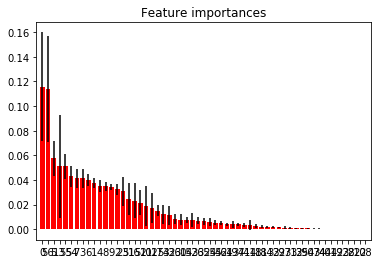

In [8]:
importances = etc.feature_importances_
std = np.std([tree.feature_importances_ for tree in etc.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. %s (%f)" % (f + 1, np.array(df_train_exp.columns)[indices[f]], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

In [9]:
# This creates a dataset for EDA manipulation
df_eda = df_train_norm.copy()

# This creates 2 new columns that summarize the Wilderness Area and Soil Type columns for ease of visualization
df_eda['Wilderness_Area'] = df_eda.iloc[:,11:15].idxmax(axis=1).str.replace('Wilderness_Area','')
df_eda['Soil_Type'] = df_eda.iloc[:,16:55].idxmax(axis=1).str.replace('Soil_Type','')

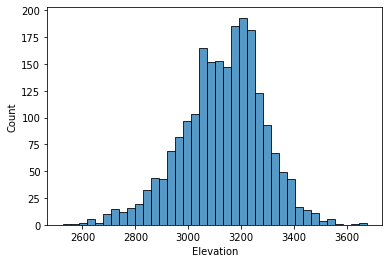

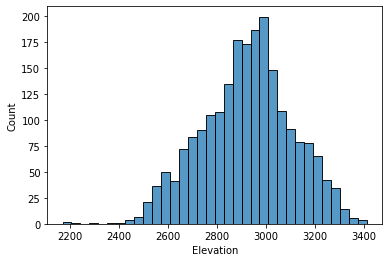

In [10]:
df_eda['Wilderness_Areas'] = df_eda['Wilderness_Area1'] + df_eda['Wilderness_Area2'] + df_eda['Wilderness_Area3'] + df_eda['Wilderness_Area4']

plt.figure()
df_one = df_eda[df_eda['Cover_Type'] == 1]
sn.histplot(data=df_one, x='Elevation')

plt.figure()
df_two = df_eda[df_eda['Cover_Type'] == 2]
sn.histplot(data=df_two, x='Elevation')

In [11]:
from sklearn.feature_selection import SelectKBest

df_train_sp = df_train_norm[(df_train_norm['Cover_Type'] == 2) | (df_train_norm['Cover_Type'] == 1)]
X , Y = df_train_sp.drop(columns=['Id','Cover_Type']).to_numpy(), df_train_sp.Cover_Type.to_numpy()
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=.33, random_state=0)
X_new = SelectKBest(k='all').fit(X_train,y_train)
scores = X_new.scores_
ind_sc = np.argsort(scores)[::-1]
j = 0
for i in range(len(ind_sc)):
    if np.isnan(scores[ind_sc[i]]):
        continue
    print(str(j) + ". " + df_train_sp.columns[ind_sc[i] + 1] + ": " + str(scores[ind_sc[i]]))
    j+=1

0. Elevation: 1061.0524255602186
1. log_Horizontal_Distance_To_Roadways: 1046.3166614199858
2. Soil_Type22: 128.75623428363835
3. Soil_Type12: 113.844352764383
4. Soil_Type23: 90.45066883207636
5. Soil_Type10: 49.94573684206583
6. Soil_Type39: 46.46658015363946
7. Soil_Type38: 40.979121042108964
8. Soil_Type11: 39.093208210768715
9. Wilderness_Area2: 35.357912818405254
10. Soil_Type13: 34.88087243129757
11. Soil_Type40: 31.173956313935655
12. Soil_Type30: 21.850720116312715
13. Wilderness_Area4: 14.344510248178247
14. Aspect: 13.384750209190711
15. Soil_Type3: 11.246958862255848
16. Soil_Type24: 10.73455001310328
17. Distance_To_Hydrology: 10.385804115987085
18. Soil_Type21: 9.910273494026507
19. Soil_Type34: 9.189160184011675
20. Soil_Type4: 9.176811455903476
21. Soil_Type26: 8.252973977436676
22. Soil_Type18: 8.162422398123036
23. Soil_Type29: 8.001919241728919
24. Horizontal_Distance_To_Fire_Points: 6.146692180803812
25. Soil_Type6: 6.113254817055784
26. Hillshade_3pm: 5.83203657884

C:\Users\vinpi\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [14 18 20 27 28 50] are constant.
  UserWarning)
C:\Users\vinpi\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [ ]:
df_train_sp.columns

### Kevin's code: 

In [12]:
def pipeline(df, version=0):
    # 0.8658068783068783
    df_n = df.copy()
    df_n = df_n.astype({c:'bool' for c in df_n.columns if "Soil_Type" in c or "Wilderness_Area" in c})
    if version >= 1: # 0.893320105820106
        col_normalize = ['Aspect','Slope','Horizontal_Distance_To_Hydrology','Vertical_Distance_To_Hydrology', 
                     'Hillshade_9am','Hillshade_Noon','Hillshade_3pm','Horizontal_Distance_To_Fire_Points',
                     'Horizontal_Distance_To_Roadways']
        df_n['log_Horizontal_Distance_To_Roadways'] = np.log(df_n['Horizontal_Distance_To_Roadways']+1)
        df_n['log_Horizontal_Distance_To_Fire_Points'] = np.log(df_n['Horizontal_Distance_To_Fire_Points']+1)
        df_n['sl_asp'] = df_n['Slope']*(np.cos(df_n['Aspect'])+ np.sin(df_n['Aspect']))
        df_n[col_normalize] = normalize(df_n[col_normalize])
        df_n.drop(columns=['Soil_Type7'],inplace=True)
    if version >= 2: # 0.8964947089947091
        df_n['sq_Elevation'] = np.power(df['Elevation'],1.5)
        df_n.drop(columns='Aspect',inplace=True)
        df_n['norm_aspect'] = df_train.Aspect.map(lambda x: x-180 if x > 180 else x+180) # np.abs(df.Aspect - 180)
        df_n['atan_aspect'] = np.arctan(df_n.norm_aspect)
    if version >= 3: # 0.9104497354497356
        df_n['Vertical_Distance_To_Hydrology'] = np.abs(df_n.Vertical_Distance_To_Hydrology)
        df_n['E-VH'] = df_train.Elevation - df_train.Vertical_Distance_To_Hydrology * .9 
        df_n['E-HH'] = df_train.Elevation - df_train.Horizontal_Distance_To_Hydrology * .5
        
        df_n['F+R'] = (df_train.Horizontal_Distance_To_Fire_Points + df_train.Horizontal_Distance_To_Roadways) ** 2
        df_n['F+H'] = (df_train.Horizontal_Distance_To_Fire_Points + df_train.Horizontal_Distance_To_Hydrology) ** 0.3
        df_n['H+R'] = (df_train.Horizontal_Distance_To_Hydrology + df_train.Horizontal_Distance_To_Roadways)
        
        df_n['abs_H-R'] = (np.abs(df_train.Horizontal_Distance_To_Hydrology - df_train.Horizontal_Distance_To_Roadways)) 
        df_n['abs_H-F'] = (np.abs(df_train.Horizontal_Distance_To_Hydrology - df_train.Horizontal_Distance_To_Fire_Points)) 
        df_n['abs_F-R'] = (np.abs(df_train.Horizontal_Distance_To_Fire_Points - df_train.Horizontal_Distance_To_Roadways)) 
    return df_n

def soils(model):
    df_train_norm_copy = df_train_norm.copy()
    soils = ['Soil_Type' + str(i) for i in range(1,41) if i != 7]
    one_ind = list(df_train_norm_copy.columns).index('Soil_Type1')
    fort_ind = list(df_train_norm_copy.columns).index('Soil_Type40')
    df_train_norm_copy['Soil_Type'] = (df_train_norm_copy.iloc[:, one_ind:fort_ind] == 1).idxmax(1).str.replace('Soil_Type','').astype(float)
    df_train_norm_copy.drop(columns=soils, inplace=True)
    return df_train_norm_copy

def wa(model):
    df_train_norm_copy = df_train_norm.copy()
    was = ['Wilderness_Area' + str(i) for i in range(1,5)]
    one_ind = list(df_train_norm_copy.columns).index('Wilderness_Area1')
    four_ind = list(df_train_norm_copy.columns).index('Wilderness_Area4')
    df_train_norm_copy['Wilderness_Area'] = (df_train_norm_copy.iloc[:, one_ind:four_ind] == 1).idxmax(1).str.replace('Wilderness_Area','').astype(float)
    df_train_norm_copy.drop(columns=was, inplace=True)
    return df_train_norm_copy

def submit(model,version):
    global df_train
    df_train_c = pipeline(df_train.copy(),version)
    df_submit = pipeline(df_test.copy(),version)
    X, Y = df_train_c.drop(columns=['Cover_Type']).to_numpy(), df_train_c.Cover_Type.to_numpy()
    model.fit(X, Y)
    pred = model.predict(df_submit.to_numpy())
    final_df = df_test.copy()
    final_df['Cover_Type'] = pred
    return final_df[['Id','Cover_Type']]

In [13]:
df_train_norm = pipeline(df_train, version=3)
df_train_norm = soils(df_train_norm)
df_train_norm = wa(df_train_norm)
df_train_norm_1_2 = df_train_norm[(df_train_norm['Cover_Type'] == 1) | (df_train_norm['Cover_Type'] == 2)]

etc = ExtraTreesClassifier(n_jobs=-1, random_state=0)
X , Y = df_train_norm_1_2.drop(columns=['Id','Cover_Type']).to_numpy(), df_train_norm_1_2.Cover_Type.to_numpy()
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=.33, random_state=0)
etc.fit(X_train,y_train)
predict_fn = lambda x: etc.predict_proba(x).astype(float)
df_train_exp=df_train_norm.drop(columns=['Id','Cover_Type'])
# Create Lime Explainer
explainer =  lime.lime_tabular.LimeTabularExplainer(X_train, feature_names = list(df_train_exp.columns), class_names = ['1','2'])

ones = [ind for ind in range(y_val.shape[0]) if y_val[ind] == 1]
twos = [ind for ind in range(y_val.shape[0]) if y_val[ind] == 2]


k = 0
examples_one = []
examples_two = []

for i in range(len(ones)):
    exp = explainer.explain_instance(X_val[ones[i]], predict_fn, num_features=10)
    probs = np.array(etc.predict_proba([X_val[ones[i]]])[0])
    if probs.argmax() != 1:
        continue
    
    k+=1
    examples_one.append(X_val[ones[i]])
    if k == 75:
        break

j = 0
for i in range(len(twos)):
    exp = explainer.explain_instance(X_val[twos[i]], predict_fn, num_features=10)
    probs = np.array(etc.predict_proba([X_val[twos[i]]])[0])
    if probs.argmax() != 0:
        continue
    
    j+=1
    examples_two.append(X_val[twos[i]])
    if j == 75:
        break


KeyboardInterrupt: 

In [ ]:
examples_one

df_one = pd.DataFrame(np.row_stack(examples_one), columns=list(df_train_exp.columns))
df_two = pd.DataFrame(np.row_stack(examples_two), columns=list(df_train_exp.columns))

df_one

In [ ]:
for i in df_one.columns:
    plt.figure()
    print(i)
    df_one[i].astype('float').hist()
    plt.xlabel(i)
    plt.figure()
    df_two[i].astype('float').hist()
    plt.xlabel(i)

In [ ]:
df_one['Elevation'].astype('float').hist()

In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(df_one.mean())
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(df_one.std())

In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(df_two.mean())
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(df_two.std())

In [ ]:
df_train_norm = pipeline(df_train, version=3)
print(df_train_norm.columns)
df_train_norm = soils(df_train_norm)
df_train_norm = wa(df_train_norm)
etc = ExtraTreesClassifier(n_jobs=-1, random_state=0)
score_model(etc, df_train_norm)

In [ ]:
df_train_exp.col

In [ ]:
df_train_exp.columns

In [ ]:
df_train_norm = pipeline(df_train, version=3)
df_train_norm = soils(df_train_norm)
df_train_norm = wa(df_train_norm)
df_train_norm_1_2 = df_train_norm[(df_train_norm['Cover_Type'] == 1) | (df_train_norm['Cover_Type'] == 2)]

etc = ExtraTreesClassifier(n_jobs=-1, random_state=0)
X , Y = df_train_norm_1_2.drop(columns=['Id','Cover_Type']).to_numpy(), df_train_norm_1_2.Cover_Type.to_numpy()
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=.33, random_state=0)
etc.fit(X_train,y_train)
predict_fn = lambda x: etc.predict_proba(x).astype(float)
df_train_exp=df_train_norm_1_2.drop(columns=['Id','Cover_Type'])
# Create Lime Explainer
explainer =  lime.lime_tabular.LimeTabularExplainer(X_train, feature_names = list(df_train_exp.columns), class_names = ['1','2'])

ones = [ind for ind in range(y_val.shape[0]) if y_val[ind] == 2]
k=0
for i in range(len(ones)):
    exp = explainer.explain_instance(X_val[ones[i]], predict_fn, num_features=10)
    probs = np.array(etc.predict_proba([X_val[ones[i]]])[0])
    if probs.argmax() != 0:
        continue
    
    k+=1
    exp.show_in_notebook(show_all=False)
    if k == 10:
        break

In [ ]:
plt.figure()
df_one = df_train_norm[df_train_norm['Cover_Type'] == 3]

sn.histplot(data=df_one, x='sl_asp')

plt.figure()
df_two = df_train_norm[df_train_norm['Cover_Type'] == 6]
sn.histplot(data=df_two, x='sl_asp')

### Light GBM

In [19]:
# !pip install lightgbm
# if not installed ^

dart 100

Model: LGBMClassifier
	cv acc: 0.8706
	split acc: 0.8585
	time taken: 41.1018
	 [0.75284 0.64965 0.86974 0.97059 0.95022 0.85286 0.96353]


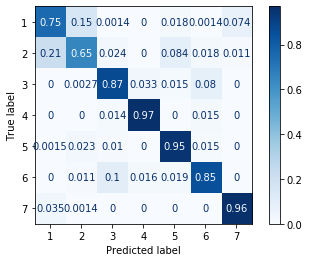

dart 200

Model: LGBMClassifier
	cv acc: 0.8796
	split acc: 0.8673
	time taken: 114.2887
	 [0.75852 0.67376 0.88738 0.96919 0.95608 0.86104 0.96494]


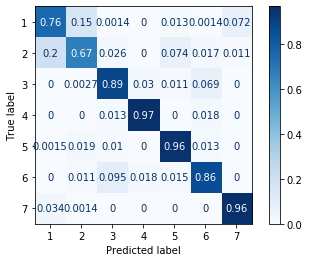

dart 300

Model: LGBMClassifier
	cv acc: 0.887
	split acc: 0.8756
	time taken: 200.7302
	 [0.77131 0.68936 0.89145 0.97479 0.96193 0.87466 0.96494]


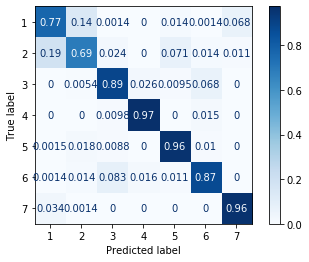

dart 500

Model: LGBMClassifier
	cv acc: 0.8933
	split acc: 0.878
	time taken: 361.4137
	 [0.77699 0.70213 0.88602 0.96919 0.9634  0.87738 0.97055]


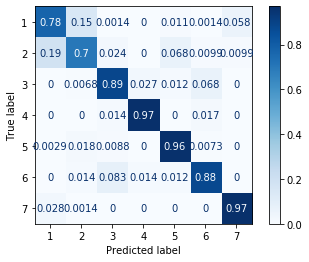

gbdt 100

Model: LGBMClassifier
	cv acc: 0.881
	split acc: 0.8683
	time taken: 15.5415
	 [0.77131 0.66667 0.8711  0.97759 0.95461 0.86785 0.96914]


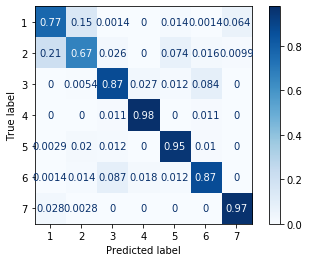

gbdt 200

Model: LGBMClassifier
	cv acc: 0.8887
	split acc: 0.8756
	time taken: 30.8107
	 [0.77273 0.6922  0.87924 0.97619 0.96047 0.8733  0.97475]


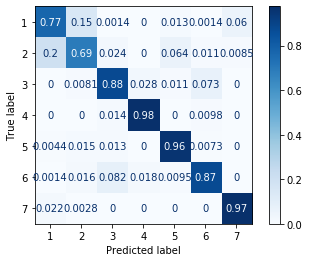

gbdt 300

Model: LGBMClassifier
	cv acc: 0.8925
	split acc: 0.8792
	time taken: 45.6018
	 [0.78409 0.69929 0.88467 0.97759 0.959   0.87466 0.97475]


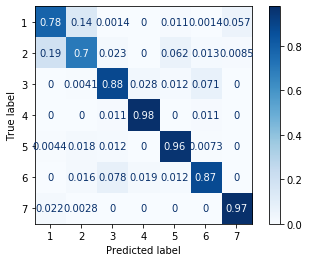

gbdt 500

Model: LGBMClassifier
	cv acc: 0.893
	split acc: 0.8792
	time taken: 89.9923
	 [0.77699 0.69929 0.88874 0.98039 0.96193 0.87466 0.97195]


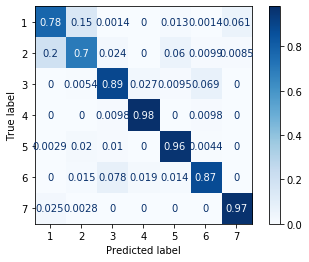

goss 100

Model: LGBMClassifier
	cv acc: 0.8774
	split acc: 0.8557
	time taken: 24.6832
	 [0.75426 0.6695  0.86431 0.95938 0.93997 0.84332 0.95933]


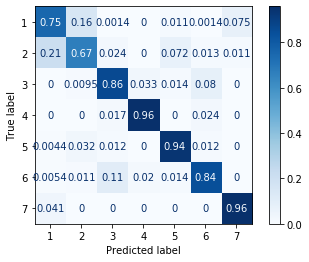

goss 200

Model: LGBMClassifier
	cv acc: 0.8843
	split acc: 0.8609
	time taken: 47.5566
	 [0.75568 0.67801 0.87246 0.95938 0.93997 0.85967 0.96073]


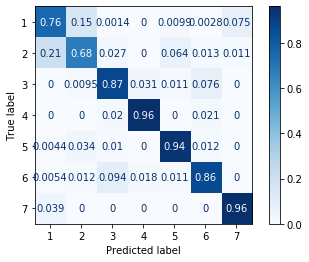

goss 300

Model: LGBMClassifier
	cv acc: 0.8882
	split acc: 0.8661
	time taken: 75.2537
	 [0.76278 0.69362 0.87653 0.96359 0.9429  0.85967 0.96353]


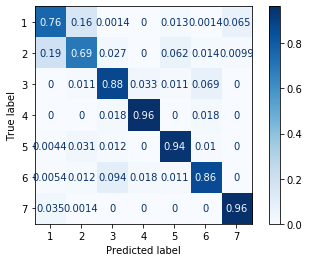

goss 500

Model: LGBMClassifier
	cv acc: 0.8909
	split acc: 0.8701
	time taken: 93.6498
	 [0.76562 0.69362 0.87653 0.96499 0.95022 0.8733  0.96634]


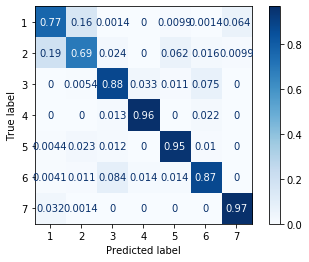

In [30]:
import lightgbm as lgb

df_train_norm = pipeline(df_train, version=3)
df_train_norm = soils(df_train_norm)
df_train_norm = wa(df_train_norm)

boosting = ['dart', 'gbdt', 'goss']
n_estimator = [100, 200, 300, 500]
for i in boosting:
    for n in n_estimator:
        print(i + ' ' + str(n))
        lgbz = lgb.LGBMClassifier(boosting_type=i, n_estimators = n)
        score_model(lgbz, df_train_norm)